### Chargement du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

airpass= pd.read_csv('AirPassengers.csv',index_col="Month",parse_dates=True)
display(airpass)
airpass.info()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


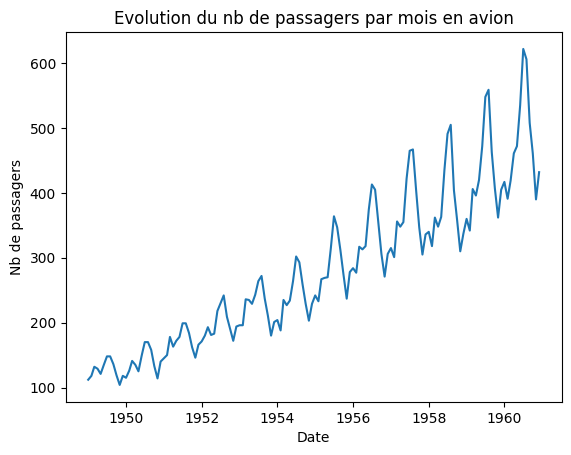

In [2]:
plt.plot(airpass)
plt.xlabel("Date")
plt.ylabel("Nb de passagers")
plt.title("Evolution du nb de passagers par mois en avion")
plt.show()

### Préparation des données

In [3]:
# Il faut un dataframe avec une colonne ds TimeStamp et une colonne y numérique
airpass['ds']=airpass.index.values
airpass = airpass.rename({"#Passengers":"y"},axis=1)
display(airpass)
airpass.info()

,y,ds
Month,,
1949-01-01,112,1949-01-01
1949-02-01,118,1949-02-01
1949-03-01,132,1949-03-01
1949-04-01,129,1949-04-01
1949-05-01,121,1949-05-01
...,...,...
1960-08-01,606,1960-08-01
1960-09-01,508,1960-09-01
1960-10-01,461,1960-10-01


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       144 non-null    int64         
 1   ds      144 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.4 KB


In [4]:
df_train = airpass.iloc[:-24]
df_test = airpass.iloc[-24:]

### Recherche des meilleurs hyperparamètres par validation croisée

In [5]:
# Paramètres fixés (modèle multiplicatif de saisonnalité annuelle)
param_fixed = {
    "seasonality_mode":'multiplicative',
    "daily_seasonality":False,
    "weekly_seasonality":False,
    "yearly_seasonality":True
}

# Paramètres à optimiser
param_grid = {
    "changepoint_prior_scale":[0.001,0.01,0.05,0.1,0.5],
    "seasonality_prior_scale":[0.01,0.1,1,10],
    "changepoint_range":[0.7,0.8,0.9,1]
}

import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model_cv = Prophet(**param_fixed, **params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(model_cv, initial='2920 days', period='365 days', horizon = '365 days', parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

d:\Sources\DS-Machine-Learning\Series-temporelles\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
23:13:46 - cmdstanpy - INFO - Chain [1] start processing
23:13:47 - cmdstanpy - INFO - Chain [1] done processing
23:13:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:13:47 - cmdstanpy - INFO - Chain [1] start processing
23:13:47 - cmdstanpy - INFO - Chain [1] done processing
23:13:47 - cmdstanpy - INFO - Chain [1] start processing
23:13:47 - cmdstanpy - INFO - Chain [1] done processing
23:13:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:13:47 - cmd

In [6]:
# Affichage des combinaisons d'hyperparamètres et de leur score RMSE
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
display(tuning_results)

# Affichage des meilleurs hyperparamètres
best_params = all_params[np.argmin(rmses)]
best_score = tuning_results['rmse'].min()
print(best_params)
print(best_score)

,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,rmse
0,0.001,0.01,0.7,38.587350
1,0.001,0.01,0.8,38.258097
2,0.001,0.01,0.9,37.883274
3,0.001,0.01,1.0,38.641547
4,0.001,0.10,0.7,16.031180
...,...,...,...,...
75,0.500,1.00,1.0,34.927896
76,0.500,10.00,0.7,33.698239
77,0.500,10.00,0.8,31.626073
78,0.500,10.00,0.9,36.129461


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'changepoint_range': 1}
16.027302117337285


### Entraînement du modèle optimisé et prédictions

In [8]:
# Entraînement
prophet = Prophet(**best_params, **param_fixed)
prophet.fit(df_train)

# Dataframe des dates de df_train et des 24 mois suivants
future = prophet.make_future_dataframe(periods=24, freq = 'ME')

# Prédictions
pred = prophet.predict(future)
display(pred)

23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:19 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,96.342890,69.663763,105.724055,96.342890,96.342890,-0.091099,-0.091099,-0.091099,-0.091099,-0.091099,-0.091099,0.0,0.0,0.0,87.566164
1,1949-02-01,98.909445,69.008473,104.377022,98.909445,98.909445,-0.130308,-0.130308,-0.130308,-0.130308,-0.130308,-0.130308,0.0,0.0,0.0,86.020706
2,1949-03-01,101.227624,84.627440,119.518674,101.227624,101.227624,0.006449,0.006449,0.006449,0.006449,0.006449,0.006449,0.0,0.0,0.0,101.880459
3,1949-04-01,103.794180,83.662678,117.489951,103.794180,103.794180,-0.029513,-0.029513,-0.029513,-0.029513,-0.029513,-0.029513,0.0,0.0,0.0,100.730904
4,1949-05-01,106.277943,86.346487,120.439249,106.277943,106.277943,-0.024792,-0.024792,-0.024792,-0.024792,-0.024792,-0.024792,0.0,0.0,0.0,103.643117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-07-31,446.470711,530.333497,567.947311,446.470710,446.470713,0.229274,0.229274,0.229274,0.229274,0.229274,0.229274,0.0,0.0,0.0,548.834987
140,1960-08-31,449.037266,453.679375,489.330225,449.037265,449.037268,0.051096,0.051096,0.051096,0.051096,0.051096,0.051096,0.0,0.0,0.0,471.981454
141,1960-09-30,451.521030,395.097313,431.438601,451.521028,451.521032,-0.083968,-0.083968,-0.083968,-0.083968,-0.083968,-0.083968,0.0,0.0,0.0,413.607637
142,1960-10-31,454.087585,342.835275,378.872711,454.087583,454.087587,-0.205133,-0.205133,-0.205133,-0.205133,-0.205133,-0.205133,0.0,0.0,0.0,360.939344


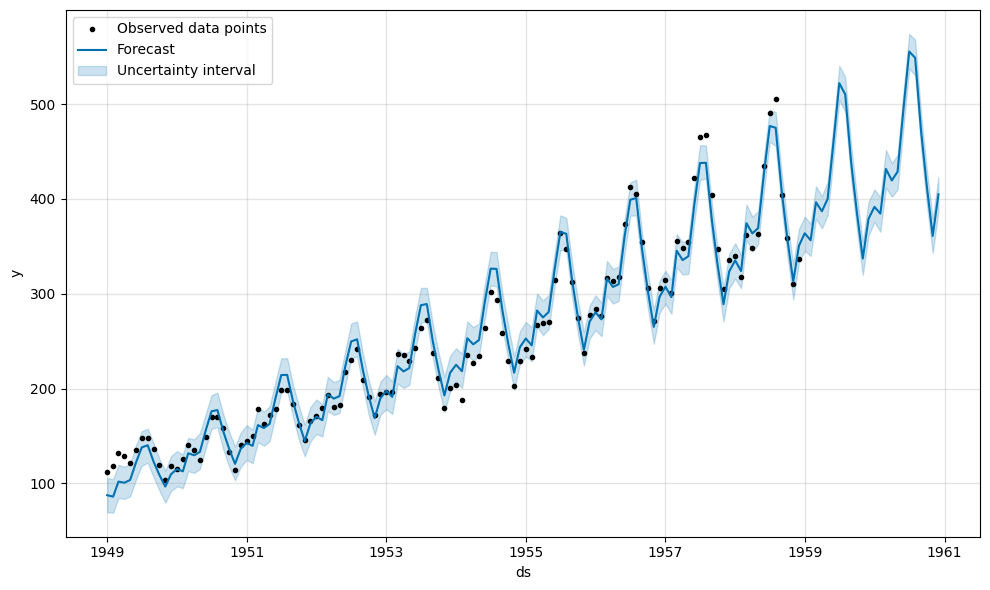

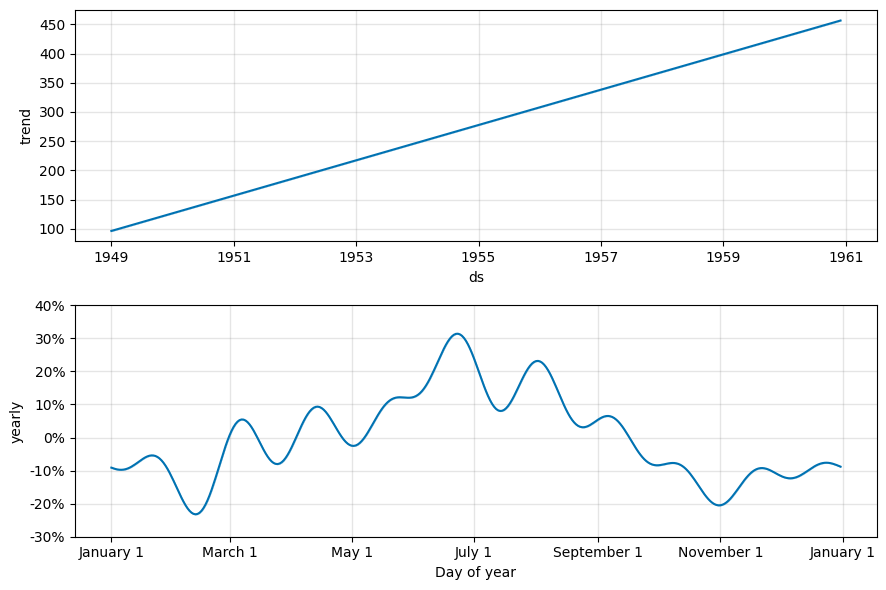

In [ ]:
# Afficher les prédictions du modèle
prophet.plot(pred)
plt.legend()
plt.show()

# Afficher les composantes de la série prédite
prophet.plot_components(pred)
plt.show()

In [10]:
from sklearn.metrics import root_mean_squared_error
print ("RMSE train:",root_mean_squared_error(df_train['y'],pred['yhat'][:-24]))
print ("RMSE test:",root_mean_squared_error(df_test['y'],pred['yhat'][-24:]))

RMSE train: 13.981555111971158
RMSE test: 32.37007127089376


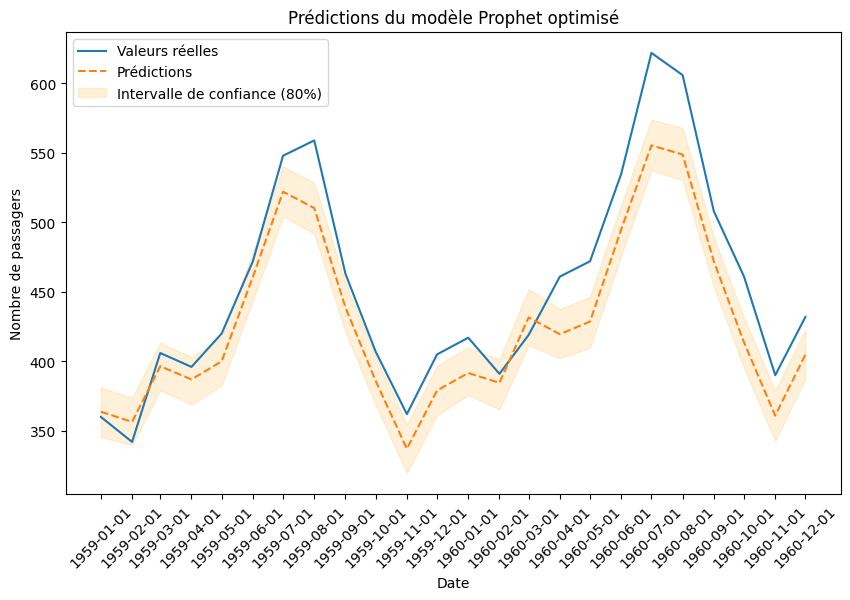

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df_test['ds'], df_test['y'], label='Valeurs réelles')
plt.plot(df_test['ds'], pred['yhat'].tail(24), label='Prédictions', linestyle='--')
plt.fill_between(df_test['ds'], pred['yhat_lower'].tail(24), pred['yhat_upper'].tail(24), 
                 color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.title('Prédictions du modèle Prophet optimisé')
plt.xlabel('Date')
plt.xticks(df_test['ds'], rotation=45)
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()